In [1]:
import pickle
import json
from nltk.corpus import twitter_samples
import nltk
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

nltk.download('twitter_samples')
twitter_samples.fileids()

/home/maria/ai-gamejam/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/maria/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [3]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

data_dct={'positive_tweets': positive_tweets,'negative_tweets':negative_tweets}

In [4]:
def sentence_transformers(tweets, model):
    tweet_embeddings=[]
    for tweet in tweets:
        encoding=model.encode(tweet)
        tweet_embeddings.append(list(encoding))
    return tweet_embeddings

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

for k in data_dct.keys():
    tweet_embeddings=sentence_transformers(data_dct[k], model)
    with open(k+'.pkl', 'wb') as file:
        pickle.dump(tweet_embeddings, file)

/home/maria/ai-gamejam/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


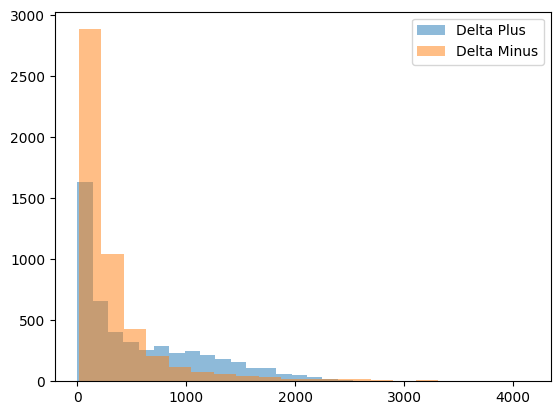

In [5]:
f='positive_tweets'

with open(f+'.pkl', 'rb') as pickle_file:
        embeddings=pickle.load(pickle_file)

def similarity_comps_pos_tweets(embeddings):
    '''
    Feel free to play around with cosine similarity thresholds and see how
    this influences game play.
    To get the number of followers and unfollowers, we calculate
    the cosine similarity between the tweets.
    Each embedding of the tweet is like a user profile.
    If similarity is above some threshold, the user represented by
    the tweet will follow you, if it is below another
    threshold he will unfollow you. 
    '''
    mat=np.array(embeddings)
    similarity_matrix=cosine_similarity(mat)
    np.fill_diagonal(similarity_matrix,0)
    delta_plus=similarity_matrix>0.45
    delta_plus=np.sum(delta_plus,axis=1)
    plt.hist(delta_plus.flatten(),bins=20,alpha=0.5, label='Delta Plus')
    delta_minus=similarity_matrix<0.1
    delta_minus=np.sum(delta_minus,axis=1)
    plt.hist(delta_minus.flatten(),bins=20,alpha=0.5,label='Delta Minus')
    plt.legend()
    return delta_plus, delta_minus


delta_plus, delta_minus=similarity_comps_pos_tweets(embeddings)

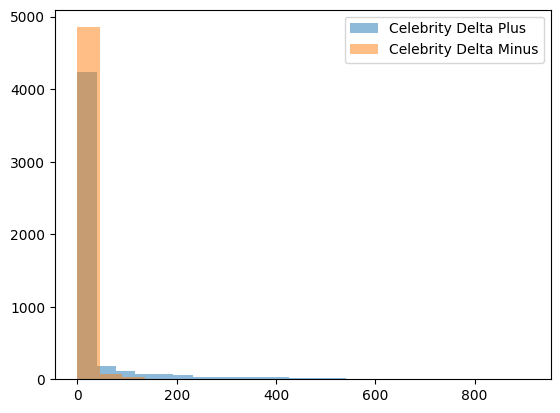

In [6]:
def celebrity_sims(celeb_embeddings,embeddings):
    '''
    Feel free to play around with cosine similarity thresholds and see how
    this influences game play.
    To get the number of followers and unfollowers, we calculate
    the cosine similarity between the tweets.
    Each embedding of the tweet is like a user profile.
    If similarity is above some threshold, the user represented by
    the tweet will follow you, if it is below another
    threshold he will unfollow you. 
    '''
    celeb_embeds=np.array(celeb_embeddings.iloc[:,1:])
    similarity_matrix=cosine_similarity(embeddings,celeb_embeds)
    delta_plus=similarity_matrix>0.6
    delta_plus=np.sum(delta_plus,axis=1)
    plt.hist(delta_plus.flatten(),bins=20,alpha=0.5, label='Celebrity Delta Plus')
    delta_minus=similarity_matrix<0.1
    delta_minus=np.sum(delta_minus,axis=1)
    plt.hist(delta_minus.flatten(),bins=20,alpha=0.5,label='Celebrity Delta Minus')
    plt.legend()
    plus_inds=np.where(similarity_matrix>0.6)
    minus_inds=np.where(similarity_matrix<0.1)
    celeb_plus=[]
    celeb_minus=[]
    for ind in range(5000):
        plus=plus_inds[1][plus_inds[0]==ind]
        celeb_plus.append(list(celeb_embeddings.iloc[plus,0]))
        minus=minus_inds[1][minus_inds[0]==ind]
        celeb_minus.append(list(celeb_embeddings.iloc[minus,0]))
    return celeb_plus, celeb_minus
        
#Celebrity data came from: https://www.kaggle.com/datasets/ahmedshahriarsakib/top-1000-twitter-celebrity-tweets-embeddings
celeb_embeddings=pd.read_csv('twitter-celebrity-embed-data.csv')
celeb_plus, celeb_minus=celebrity_sims(celeb_embeddings,embeddings)

In [7]:
def generate_json(tweets,delta_plus,delta_minus,celeb_plus,celeb_minus):
    json_dct={}
    for ind in range(len(tweets)):
        json_dct[ind]={'tweet_text': str(tweets[ind]), 'new_followers':str(delta_plus[ind]), 'new_unfollowers': str(delta_minus[ind]),'new_celeb_followers': celeb_plus[ind], 'new_celeb_unfollowers': celeb_minus[ind]}
    return json_dct
    

json_dct=generate_json(positive_tweets,delta_plus,delta_minus,celeb_plus,celeb_minus)

with open('pos_tweets.json', 'w') as json_file:
    json.dump(json_dct, json_file)

/home/maria/ai-gamejam/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


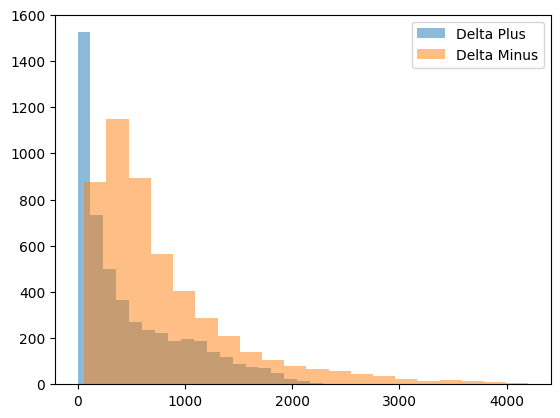

In [11]:
f='negative_tweets'

with open(f+'.pkl', 'rb') as pickle_file:
        embeddings=pickle.load(pickle_file)

def similarity_comps_neg_tweets(embeddings):
    '''
    Feel free to play around with cosine similarity thresholds and see how
    this influences game play.
    To get the number of followers and unfollowers, we calculate
    the cosine similarity between the tweets.
    Each embedding of the tweet is like a user profile.
    If similarity is above some threshold, the user represented by
    the tweet will follow you, if it is below another
    threshold he will unfollow you. 
    '''
    mat=np.array(embeddings)
    similarity_matrix=cosine_similarity(mat)
    np.fill_diagonal(similarity_matrix,0)
    delta_plus=similarity_matrix>0.4
    delta_plus=np.sum(delta_plus,axis=1)
    plt.hist(delta_plus.flatten(),bins=20,alpha=0.5, label='Delta Plus')
    delta_minus=similarity_matrix<0.1
    delta_minus=np.sum(delta_minus,axis=1)
    plt.hist(delta_minus.flatten(),bins=20,alpha=0.5,label='Delta Minus')
    plt.legend()
    return delta_plus, delta_minus


delta_plus, delta_minus=similarity_comps_pos_tweets(embeddings)

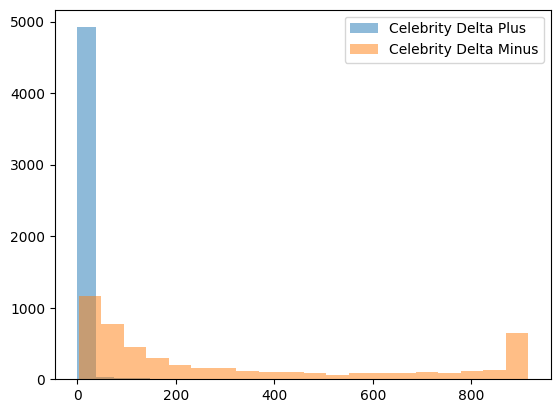

In [14]:
def celebrity_sims_neg(celeb_embeddings,embeddings):
    '''
    Feel free to play around with cosine similarity thresholds and see how
    this influences game play.
    To get the number of followers and unfollowers, we calculate
    the cosine similarity between the tweets.
    Each embedding of the tweet is like a user profile.
    If similarity is above some threshold, the user represented by
    the tweet will follow you, if it is below another
    threshold he will unfollow you. 
    '''
    celeb_embeds=np.array(celeb_embeddings.iloc[:,1:])
    similarity_matrix=cosine_similarity(embeddings,celeb_embeds)
    delta_plus=similarity_matrix>0.65
    delta_plus=np.sum(delta_plus,axis=1)
    plt.hist(delta_plus.flatten(),bins=20,alpha=0.5, label='Celebrity Delta Plus')
    delta_minus=similarity_matrix<0.3
    delta_minus=np.sum(delta_minus,axis=1)
    plt.hist(delta_minus.flatten(),bins=20,alpha=0.5,label='Celebrity Delta Minus')
    plt.legend()
    plus_inds=np.where(similarity_matrix>0.65)
    minus_inds=np.where(similarity_matrix<0.3)
    celeb_plus=[]
    celeb_minus=[]
    for ind in range(5000):
        plus=plus_inds[1][plus_inds[0]==ind]
        celeb_plus.append(list(celeb_embeddings.iloc[plus,0]))
        minus=minus_inds[1][minus_inds[0]==ind]
        celeb_minus.append(list(celeb_embeddings.iloc[minus,0]))
    return celeb_plus, celeb_minus
        
#Celebrity data came from: https://www.kaggle.com/datasets/ahmedshahriarsakib/top-1000-twitter-celebrity-tweets-embeddings
celeb_embeddings=pd.read_csv('twitter-celebrity-embed-data.csv')
celeb_plus, celeb_minus=celebrity_sims_neg(celeb_embeddings,embeddings)

In [ ]:
json_dct=generate_json(positive_tweets,delta_plus,delta_minus,celeb_plus,celeb_minus)

with open('pos_tweets.json', 'w') as json_file:
    json.dump(json_dct, json_file)